In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
#import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller

+ Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.
+ An ARIMA model is characterized by 3 terms: p, d, q, where
    + p is the order of the AR term
    + q is the order of the MA term
    + d is the number of differencing required to make the time series stationary

# Exploratory Data Analysis (EDA):  
understand the data better, visualize the data to see if there are any noticeable trends or patterns.

In [18]:
df = pd.read_csv("data_daily.csv")
df['Date'] = pd.to_datetime(df['# Date'])
df['Month']= df['Date'].dt.month
df = df.drop(columns= ['# Date', 'Date'])
train = df.groupby('Month').sum().reset_index()
data_series = train["Receipt_Count"]
data_series


0     236736687
1     220033460
2     248608625
3     250644830
4     263151748
5     260656840
6     274776003
7     283943231
8     281146154
9     295965185
10    296085162
11    309948684
Name: Receipt_Count, dtype: int64

In [19]:
train = df.groupby('Month').sum().reset_index()
data_series = train["Receipt_Count"]
data_series

0     236736687
1     220033460
2     248608625
3     250644830
4     263151748
5     260656840
6     274776003
7     283943231
8     281146154
9     295965185
10    296085162
11    309948684
Name: Receipt_Count, dtype: int64

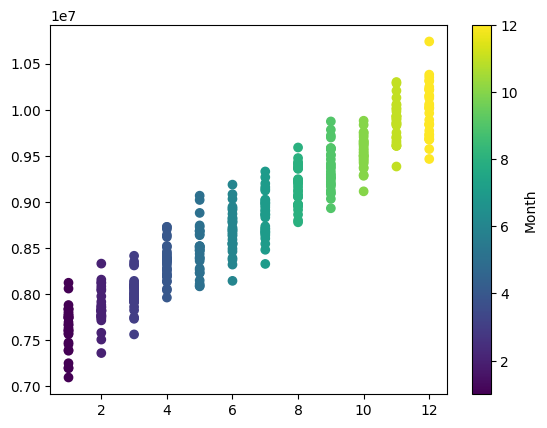

In [20]:
plt.scatter(df['Month'], df['Receipt_Count'], c= df['Month'], cmap='viridis')
plt.colorbar(label = 'Month')

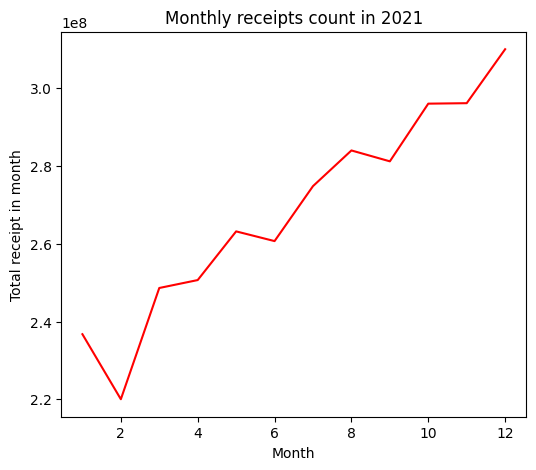

In [21]:
def plot_df(x, y, title = "", xlabel = 'Month', ylabel = 'Total receipt in month', dpi = 100):
    plt.figure(figsize=(6,5), dpi = dpi)
    plt.plot(x, y, color='red')
    plt.gca().set(title = title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(x=train['Month'].values, y=train['Receipt_Count'].values, title='Monthly receipts count in 2021')

Graph before ADF test

[ 1.          0.70047195  0.45700256  0.23120304  0.0867828  -0.0882348
 -0.27604204]


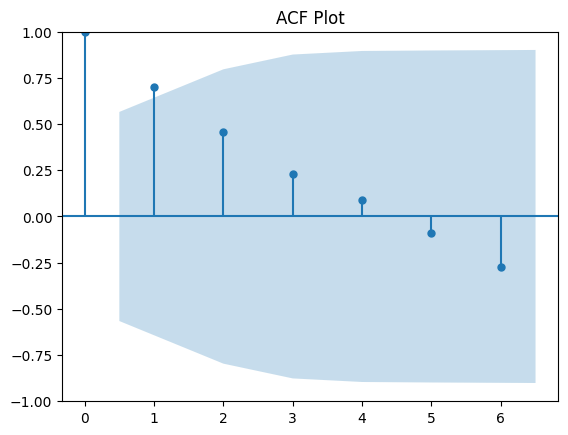

In [22]:
print(acf(data_series, nlags = 6))
plot_acf(data_series, lags = 6)
plt.title('ACF Plot')
plt.show()

[ 1.          0.76415122 -0.08537928 -0.19690292 -0.03172351]


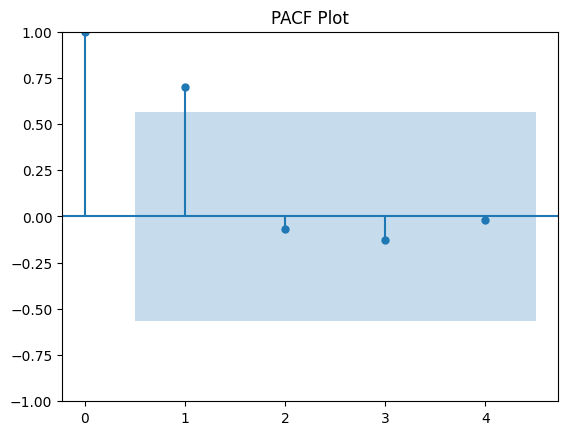

In [23]:
print(pacf(data_series, nlags = 4))
plot_pacf(data_series, lags = 4)
plt.title('PACF Plot')
plt.show()

 Augmented Dickey-Fuller (ADF) test

In [24]:
def adfuller_test(data_series):
  result_adfuller_test = adfuller(data_series)

  adf_stats= result_adfuller_test[0]
  pval = result_adfuller_test[1]
  critcal = result_adfuller_test[4]['5%']
  return adf_stats, pval, critcal

def find_differencing_order(series, max_diff = 5):
  d = 0
  adf_stats, pval, critcal = adfuller_test(series)
  while(adf_stats > critcal) and d < max_diff:
    d += 1
    series = series.diff().dropna()
    adf_stats, pval, critcal = adfuller_test(series)
    return d

d = find_differencing_order(data_series)
d

1

In [25]:
# Differencing the Data with d = 1
train_after_diff = data_series.diff().dropna().values

Graph after Differencing: The ACF and PACF of the differenced data can provide insights into the lag structure of the stationary series.

[ 1.         -0.63917897  0.25011665 -0.19901396  0.13873026  0.05801213
 -0.27588043]


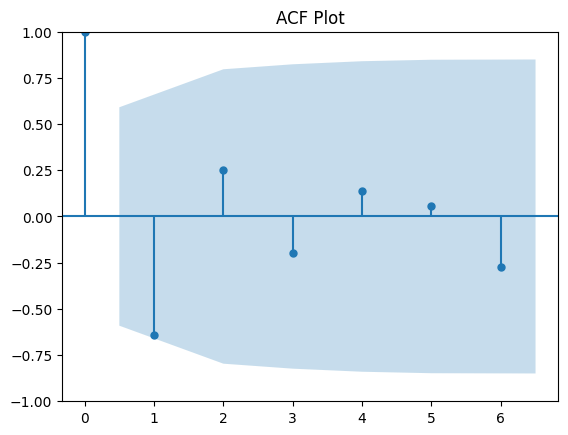

In [26]:
# The ACF plot gives an indication of the MA order
print(acf(train_after_diff, nlags = 6))
plot_acf(train_after_diff, lags = 6)
plt.title('ACF Plot')
plt.show()

[ 1.         -0.70309686 -0.37307483 -0.55328097 -0.70964475]


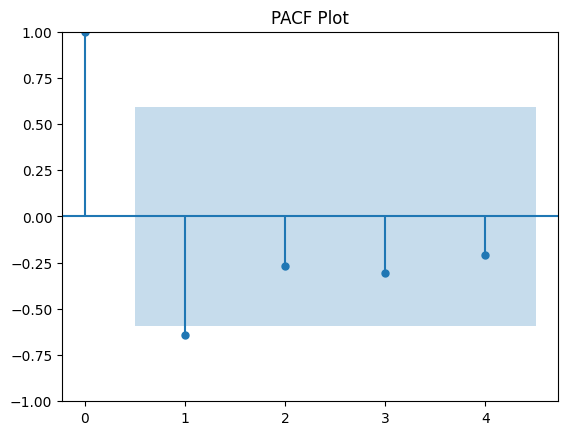

In [27]:
# The PACF plot gives an indication of the AR order.
print(pacf(train_after_diff, nlags = 4))
plot_pacf(train_after_diff, lags = 4)
plt.title('PACF Plot')
plt.show()

# Model (ARIMA)

In [28]:
class Arima_module(torch.nn.Module):
    # The current value is a function of the prev value
    # A(t) = a*A(t-1)+ e
    def __init__(self, d= 1):
        super(Arima_module, self).__init__()
        self.alpha = torch.rand(1, requires_grad= True)
        self.phi = torch.rand(1, requires_grad= True)
        self.drift = torch.rand(1, requires_grad= True)
        self.theta = torch.rand(1, requires_grad= True)
        self.d = d

    def difference(self, data):
      diff = pd.Series(data.numpy()).diff(self.d).dropna().values
      return torch.tensor(diff, dtype = torch.float32)

    def reverse_difference(self, last_obs, diff_value):
      return last_obs + diff_value

    def forward_prob(self, diff_data, error):
      # AR(1): Y_t = alpha + \phi Y_{t-1}+ d
        #diff_data = self.difference(obs_data) #difference the orignal data 1 time
        x = self.alpha + self.phi*diff_data + self.theta*error + self.drift
        return x
    # obs_data is the original data
    def ml_fit(self, obs_data, num_iterations = 100):
        diff_data = self.difference(obs_data) #difference the orignal data 1 time
        param = torch.tensor([self.alpha, self.phi, self.drift], requires_grad=True)
        optimizer = torch.optim.SGD([param], lr = 0.01, momentum= 0.9)
        error = torch.zeros_like(diff_data)
        for values in range(num_iterations):
            for t in range(1, len(diff_data)):
                error[t] = diff_data[t] - self.forward_prob(diff_data[t-1], error[t-1])
            loss_fn = self.likelihood_fun(param, diff_data.clone())
            loss_fn.mean().backward(retain_graph = True)
            optimizer.step()
            optimizer.zero_grad()
        return

    def likelihood_fun(self, param, diff_data):
        sum = 0
        alpha = param[0]
        phi = param[1]
        drift = param[2]
        for val in diff_data:
            sum = sum + phi*val + alpha + drift
        return -sum

    def params(self):
        return self.alpha, self.phi, self.drift

    def predict_2022(self, obs_data, num_month = 13):
      predictions = []
      error = 0
      for month in range(1, num_month):
        pred_diff = self.forward_prob(obs_data[-1], error)
        pred = self.reverse_difference(obs_data[-1].item(), pred_diff.item())
        predictions.append(pred)
        obs_data = torch.cat((obs_data, torch.tensor([pred], dtype=torch.float32)))
      return predictions


In [30]:
model = Arima_module()
obs_data = torch.tensor(data_series, dtype = torch.float32)
model.ml_fit(obs_data, num_iterations= 5000)
predictions = model.predict_2022(obs_data)

print(predictions)

[529413648.0, 904274912.0, 1544563776.0, 2638221056.0, 4506263040.0, 7697007360.0, 13147018240.0, 22456011776.0, 38356414464.0, 65515395072.0, 111904804864.0, 191141093376.0]


Prediction

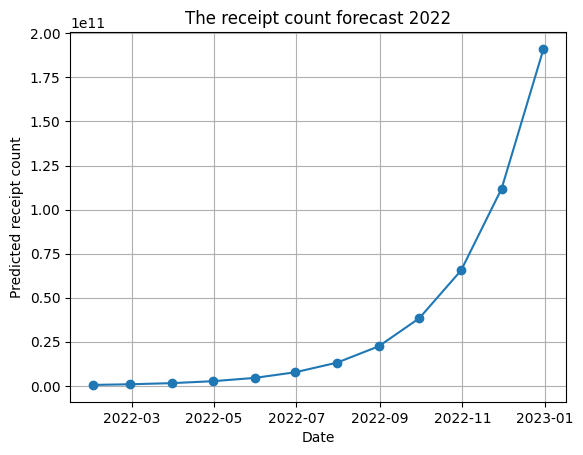

[529413648.0, 904274912.0, 1544563776.0, 2638221056.0, 4506263040.0, 7697007360.0, 13147018240.0, 22456011776.0, 38356414464.0, 65515395072.0, 111904804864.0, 191141093376.0]


In [31]:
months = pd.date_range(start='2022-01-01', end = '2022-12-31', freq= 'M')
plt.plot(months, predictions, label = "Prediction for 2022", marker = 'o')
plt.title('The receipt count forecast 2022')
plt.xlabel('Date')
plt.ylabel('Predicted receipt count')
plt.grid()
plt.show()
print(predictions)

## Reference

In [32]:
# Fit the ARIMA model
# For this example, I'm using (1,1,0) which is AR(1) with first differencing. Adjust p,d,q as needed.
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = ARIMA(data_series, order=(1,1,1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Receipt_Count   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -195.838
Date:                Sun, 01 Oct 2023   AIC                            397.676
Time:                        20:45:18   BIC                            398.870
Sample:                             0   HQIC                           396.924
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.009    112.802      0.000       0.983       1.017
ma.L1         -0.9990      0.243     -4.116      0.000      -1.475      -0.523
sigma2      7.464e+13   3.31e-15   2.25e+28      0.0

C:\Users\tnguy\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


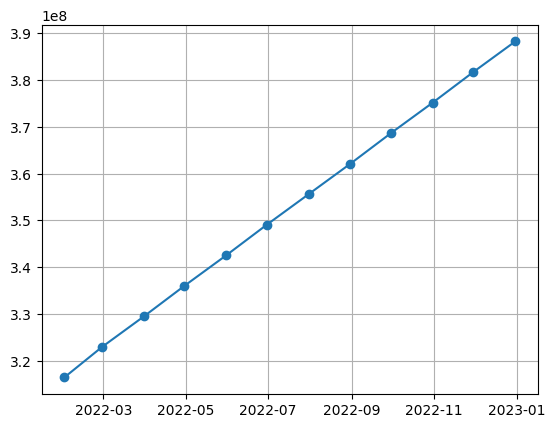

12    3.164699e+08
13    3.229910e+08
14    3.295120e+08
15    3.360329e+08
16    3.425537e+08
17    3.490743e+08
18    3.555948e+08
19    3.621152e+08
20    3.686354e+08
21    3.751556e+08
22    3.816756e+08
23    3.881955e+08
Name: predicted_mean, dtype: float64


In [33]:
# Forecast the next 12 months
forecast = model_fit.forecast(steps=12)
months = pd.date_range(start='2022-01-01', end = '2022-12-31', freq= 'M')
plt.plot(months, forecast, label = "Prediction for 2022", marker = 'o')
plt.grid()
plt.show()
print(forecast)

In [34]:
"""
def autocorrelation(y, lag):
    mean_y = torch.mean(y)
    n = len(y)
    print((y[lag:] - mean_y).shape)
    print((y[:n-lag] - mean_y).shape)
    num = torch.sum((y[lag:] - mean_y)*(y[:n-lag] - mean_y))
    den = torch.sum((y - mean_y)**2)
    return (num/den).item()

#  The least squares solution is used to find the linear relationship between the time series values at the given lag.
def partial_autocorrelation(y, lag):
    # partial autocorrelation function (PACF) at lag 0 represents the correlation of a time series with itself
    if lag == 0:
        return 1
    else:
        # unsqueeze(1): used to add an additional dimension to the tensor,
        # effectively converting a 1D tensor into a 2D tensor where the new dimension has size 1.

        # torch.lstsq() function to solve the least squares problem.
        # The function tries to find x such that Ax = b, where A is the second argument
        # and b is the first argument. The function returns a tuple, where the first element contains the solution.
        return torch.linalg.lstsq(y[lag:].unsqueeze(1), y[:-lag].unsqueeze(1))[0][lag].item()

lags = 6
y = torch.tensor(train['Receipt_Count'].values, dtype= torch.float32)

afc_value = [autocorrelation(y, lag) for lag in range(lags)]
pafc_values = [partial_autocorrelation(y, lag) for lag in range(lags)]

# PLot ACF
plt.stem(range(lags), afc_value, use_line_collection= True)
plt.title('ACF Plot')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

plt.stem(range(lags), pafc_values, use_line_collection= True)
plt.title('PACF')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()
"""

"\ndef autocorrelation(y, lag):\n    mean_y = torch.mean(y)\n    n = len(y)\n    print((y[lag:] - mean_y).shape)\n    print((y[:n-lag] - mean_y).shape)\n    num = torch.sum((y[lag:] - mean_y)*(y[:n-lag] - mean_y))\n    den = torch.sum((y - mean_y)**2)\n    return (num/den).item()\n\n#  The least squares solution is used to find the linear relationship between the time series values at the given lag.\ndef partial_autocorrelation(y, lag):\n    # partial autocorrelation function (PACF) at lag 0 represents the correlation of a time series with itself\n    if lag == 0:\n        return 1\n    else:\n        # unsqueeze(1): used to add an additional dimension to the tensor,\n        # effectively converting a 1D tensor into a 2D tensor where the new dimension has size 1.\n\n        # torch.lstsq() function to solve the least squares problem.\n        # The function tries to find x such that Ax = b, where A is the second argument\n        # and b is the first argument. The function returns a t